In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sklearn import metrics, model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
# Choose a target
target = "NR-AR"

# import the processed dataset for algorithms what require scaled variables
print('Load Pickle')
pickle_in = open(target + "_processeddata.pkl", "rb")
[param, train_smi, test_smi, train_mol_id, test_mol_id,  X_train, X_test, y_train, y_test] = pickle.load(pickle_in)
pickle_in.close()
print('Finished')

# standardization
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Load Pickle
Finished


We generate a random forest classifier in the full feature space with the hyperparameters optimized in `RandForrClass.ipynb`:

In [3]:
# generate a random forest model
rf = RandomForestClassifier(n_estimators=500, class_weight='balanced', max_depth=None, min_samples_leaf=4, min_samples_split=2, random_state=100)
rf.fit(X_train, y_train)

print('Make predictions')
y_pred_train = rf.predict(X_train) # make predictions for the training set
y_pred_test = rf.predict(X_test) # make predictions for the test set
print('Finished')

Make predictions
Finished


Calculate performance metrics for the model in full feature space

In [4]:
# Evaluate the model: calculate the evaluation metrics
acc_train = metrics.accuracy_score(y_train, y_pred_train)
acc_test = metrics.accuracy_score(y_test, y_pred_test)
sens_train = metrics.recall_score(y_train, y_pred_train, pos_label=1)
sens_test = metrics.recall_score(y_test, y_pred_test, pos_label=1)
spec_train = metrics.recall_score(y_train, y_pred_train, pos_label=0)
spec_test = metrics.recall_score(y_test, y_pred_test, pos_label=0)
prec_train = metrics.precision_score(y_train, y_pred_train, pos_label=1)
prec_test = metrics.precision_score(y_test, y_pred_test, pos_label=1)

# print the evaluation metrics in a formatted manner
print("       | accuracy | sensitivity | specificity | precision ")
print(f"train  |   {acc_train:.2f}   |     {sens_train:.2f}    |    {spec_train:.2f}     |   {prec_train:.2f}")
print(f"test   |   {acc_test:.2f}   |     {sens_test:.2f}    |    {spec_test:.2f}     |   {prec_test:.2f}")

# calculate the F1-Score
precision_train, recall_train, f1_score_train, _ = metrics.precision_recall_fscore_support(y_train, y_pred_train, average='binary')
precision_test, recall_test, f1_score_test, _ = metrics.precision_recall_fscore_support(y_test, y_pred_test, average='binary')

print(f'\ntrain F1-Score: {f1_score_train:.2f}')
print(f'test F1-Score: {f1_score_test:.2f}')

       | accuracy | sensitivity | specificity | precision 
train  |   1.00   |     1.00    |    1.00     |   0.92
test   |   0.97   |     0.39    |    1.00     |   0.83

train F1-Score: 0.96
test F1-Score: 0.53


train ROC-AUC: 1.00
test ROC-AUC: 0.78
train PR-AUC: 0.96
test PR-AUC: 0.49


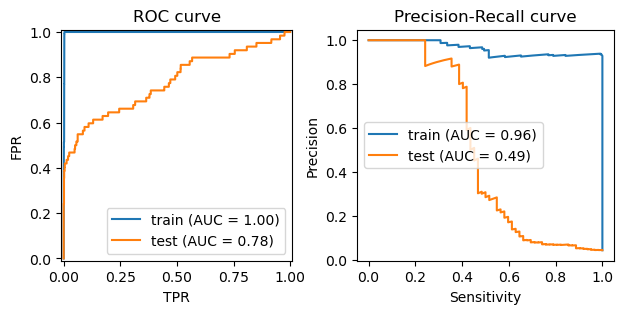

In [5]:
# create a figurespace with 3 subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(7.3, 3))

# ROC-AUC plots as the first subplot
y_train_prob = rf.predict_proba(X_train)[:,1]
print(f'train ROC-AUC: {metrics.roc_auc_score(y_train, y_train_prob):.2f}')
y_test_prob = rf.predict_proba(X_test)[:,1]
print(f'test ROC-AUC: {metrics.roc_auc_score(y_test, y_test_prob):.2f}')
metrics.RocCurveDisplay.from_predictions(y_train, y_train_prob, name="train", ax=ax1)
metrics.RocCurveDisplay.from_predictions(y_test,y_test_prob, name="test", ax=ax1)
ax1.set_xlabel('TPR')
ax1.set_ylabel('FPR')
ax1.title.set_text('ROC curve')

precision_curve_train, recall_curve_train, _ = metrics.precision_recall_curve(y_train, y_train_prob)
print(f'train PR-AUC: {metrics.auc(recall_curve_train, precision_curve_train):.2f}')
precision_curve_test, recall_curve_test, _ = metrics.precision_recall_curve(y_test, y_test_prob)
print(f'test PR-AUC: {metrics.auc(recall_curve_test, precision_curve_test):.2f}')
# plot PR curves
ax2.plot(recall_curve_train, precision_curve_train, label='train (AUC = %0.2f)' % metrics.auc(recall_curve_train, precision_curve_train))
ax2.plot(recall_curve_test, precision_curve_test, label='test (AUC = %0.2f)' % metrics.auc(recall_curve_test, precision_curve_test))
ax2.set_xlabel('Sensitivity')
ax2.set_ylabel('Precision')
ax2.legend()
ax2.title.set_text('Precision-Recall curve')

We now reduce the amount of features using feature importance during training. Model-based methods like Random Forest feature importance (via SelectFromModel) tend to work well in imbalanced data sets because they consider how features contribute to model performance, even in the presence of class imbalance.

We select the most important 20 features and rebuild a random forest based solely on them.

In [6]:
from sklearn.feature_selection import SelectFromModel
n_sel = 20
rrf_sel1 = SelectFromModel(rf, prefit=False, max_features=n_sel,
                          importance_getter='auto').fit(X_train, y_train)
# extract and print the selection
feat_train_rf1 = X_train[:, rrf_sel1.get_support()]
feat_test_rf1 = X_test[:, rrf_sel1.get_support()]
# fit an updated model with the selected features
rf.fit(feat_train_rf1, y_train)

param_sel_rf1 = np.array(param)[rrf_sel1.get_support()]
np.save('param_sel_rf1', param_sel_rf1)
print(param_sel_rf1)

['MaxAbsEStateIndex' 'SPS' 'FpDensityMorgan3' 'AvgIpc' 'BalabanJ'
 'BertzCT' 'Chi2n' 'Chi3n' 'Chi4n' 'Chi4v' 'PEOE_VSA7' 'SMR_VSA4'
 'SMR_VSA5' 'SlogP_VSA4' 'NumAliphaticCarbocycles' 'NumAliphaticRings'
 'NumSaturatedCarbocycles' 'NumSaturatedRings' 'RingCount' 'fr_bicyclic']


We check the performance of the new random forest built in the selected feature space.

In [7]:
FI_rf1_df = pd.DataFrame({'feature': param_sel_rf1, 'importance': rf.feature_importances_})
FI_rf1_df = FI_rf1_df.sort_values(by='importance', key=abs, ascending=False)
print(FI_rf1_df)

print('Make predictions')
y_pred_train = rf.predict(feat_train_rf1) # make predictions for the training set
y_pred_test = rf.predict(feat_test_rf1) # make predictions for the test set
print('Finished')

acc_train = metrics.accuracy_score(y_train, y_pred_train)
acc_test = metrics.accuracy_score(y_test, y_pred_test)
sens_train = metrics.recall_score(y_train, y_pred_train, pos_label=1)
sens_test = metrics.recall_score(y_test, y_pred_test, pos_label=1)
spec_train = metrics.recall_score(y_train, y_pred_train, pos_label=0)
spec_test = metrics.recall_score(y_test, y_pred_test, pos_label=0)
prec_train = metrics.precision_score(y_train, y_pred_train, pos_label=1)
prec_test = metrics.precision_score(y_test, y_pred_test, pos_label=1)

# print the evaluation metrics in a formatted manner
print("       | accuracy | sensitivity | specificity | precision ")
print(f"train  |   {acc_train:.2f}   |     {sens_train:.2f}    |    {spec_train:.2f}     |   {prec_train:.2f}")
print(f"test   |   {acc_test:.2f}   |     {sens_test:.2f}    |    {spec_test:.2f}     |   {prec_test:.2f}")

# calculate the F1-Score
precision_train, recall_train, f1_score_train, _ = metrics.precision_recall_fscore_support(y_train, y_pred_train, average='binary')
precision_test, recall_test, f1_score_test, _ = metrics.precision_recall_fscore_support(y_test, y_pred_test, average='binary')

print(f'\ntrain F1-Score: {f1_score_train:.2f}')
print(f'test F1-Score: {f1_score_test:.2f}')

                    feature  importance
1                       SPS    0.086231
8                     Chi4n    0.071436
14  NumAliphaticCarbocycles    0.070954
5                   BertzCT    0.064739
19              fr_bicyclic    0.061482
7                     Chi3n    0.055777
9                     Chi4v    0.055284
0         MaxAbsEStateIndex    0.054298
2          FpDensityMorgan3    0.053140
4                  BalabanJ    0.050478
3                    AvgIpc    0.049400
6                     Chi2n    0.048657
11                 SMR_VSA4    0.047439
10                PEOE_VSA7    0.043955
12                 SMR_VSA5    0.043634
15        NumAliphaticRings    0.041933
16  NumSaturatedCarbocycles    0.035706
13               SlogP_VSA4    0.033297
18                RingCount    0.018248
17        NumSaturatedRings    0.013913
Make predictions
Finished
       | accuracy | sensitivity | specificity | precision 
train  |   1.00   |     1.00    |    1.00     |   0.91
test   |   0.97   | 

train ROC-AUC: 1.00
test ROC-AUC: 0.77
train PR-AUC: 0.95
test PR-AUC: 0.46


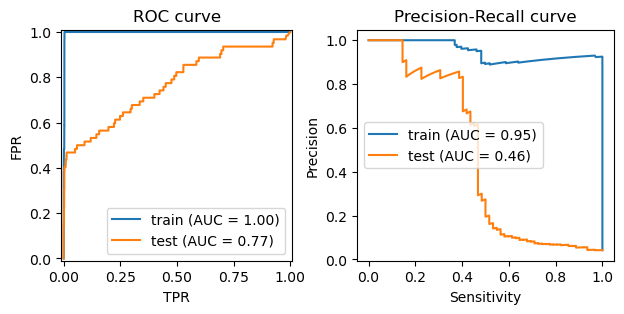

In [8]:
# create a figurespace with 3 subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(7.3, 3))

# ROC-AUC plots as the first subplot
y_train_prob = rf.predict_proba(feat_train_rf1)[:,1]
print(f'train ROC-AUC: {metrics.roc_auc_score(y_train, y_train_prob):.2f}')
y_test_prob = rf.predict_proba(feat_test_rf1)[:,1]
print(f'test ROC-AUC: {metrics.roc_auc_score(y_test, y_test_prob):.2f}')
metrics.RocCurveDisplay.from_predictions(y_train, y_train_prob, name="train", ax=ax1)
metrics.RocCurveDisplay.from_predictions(y_test,y_test_prob, name="test", ax=ax1)
ax1.set_xlabel('TPR')
ax1.set_ylabel('FPR')
ax1.title.set_text('ROC curve')

precision_curve_train, recall_curve_train, _ = metrics.precision_recall_curve(y_train, y_train_prob)
print(f'train PR-AUC: {metrics.auc(recall_curve_train, precision_curve_train):.2f}')
precision_curve_test, recall_curve_test, _ = metrics.precision_recall_curve(y_test, y_test_prob)
print(f'test PR-AUC: {metrics.auc(recall_curve_test, precision_curve_test):.2f}')
# plot PR curves
ax2.plot(recall_curve_train, precision_curve_train, label='train (AUC = %0.2f)' % metrics.auc(recall_curve_train, precision_curve_train))
ax2.plot(recall_curve_test, precision_curve_test, label='test (AUC = %0.2f)' % metrics.auc(recall_curve_test, precision_curve_test))
ax2.set_xlabel('Sensitivity')
ax2.set_ylabel('Precision')
ax2.legend()
ax2.title.set_text('Precision-Recall curve')

The performance of the new random forest in reduced feature space is very close to that of the random forest in full space, and in principle can still be optimized. Cross-validation can be used to check if the new model is more generalizable.

In [9]:
# Define a stratified k-fold cross-validation (to maintain class balance in each fold)
cv = model_selection.StratifiedKFold(n_splits=5)

# Custom scoring for F1, Precision, Recall, AUC-PR
scoring = {
    'precision': metrics.make_scorer(metrics.precision_score),
    'recall': metrics.make_scorer(metrics.recall_score),
    'f1': metrics.make_scorer(metrics.f1_score),
    'auc_pr': metrics.make_scorer(metrics.average_precision_score),  # For AUC-PR
    'roc_auc': 'roc_auc'  # For AUC-ROC
}

# Perform cross-validation and evaluate scores
cv_results = model_selection.cross_validate(rf, X_train, y_train, cv=cv, scoring=scoring)

# Print the scores for each fold
for metric in scoring.keys():
    print(f"{metric}: {cv_results[f'test_{metric}']}")

# Print the mean and standard deviation of the scores
for metric in scoring.keys():
    print(f"{metric}: {cv_results[f'test_{metric}'].mean():.2f} +/- {cv_results[f'test_{metric}'].std():.2f}")

precision: [0.88461538 0.81481481 0.90322581 0.76923077 0.77777778]
recall: [0.46       0.44       0.57142857 0.40816327 0.57142857]
f1: [0.60526316 0.57142857 0.7        0.53333333 0.65882353]
auc_pr: [0.4301389  0.38259418 0.53420132 0.33892871 0.46251673]
roc_auc: [0.80792453 0.81589398 0.8249262  0.77831564 0.8507802 ]
precision: 0.83 +/- 0.05
recall: 0.49 +/- 0.07
f1: 0.61 +/- 0.06
auc_pr: 0.43 +/- 0.07
roc_auc: 0.82 +/- 0.02


In [10]:
# check correlations in reduced feature set
tox_red = pd.DataFrame(feat_train_rf1, columns=param_sel_rf1)
tox_red[target] = y_train
correlation_matrix = tox_red.corr()
correlation_matrix = correlation_matrix.sort_values(by=target, ascending=False, key=abs, axis=0)
correlation_matrix = correlation_matrix.sort_values(by=target, ascending=False, key=abs, axis=1)
print(correlation_matrix.head(20))

                            NR-AR  NumAliphaticCarbocycles  \
NR-AR                    1.000000                 0.466382   
NumAliphaticCarbocycles  0.466382                 1.000000   
NumSaturatedCarbocycles  0.428584                 0.917665   
fr_bicyclic              0.373309                 0.620306   
SMR_VSA4                 0.344899                 0.712983   
SPS                      0.328694                 0.733433   
SlogP_VSA4               0.306266                 0.608651   
NumAliphaticRings        0.285420                 0.653819   
Chi4n                    0.284111                 0.593288   
NumSaturatedRings        0.249635                 0.577351   
Chi3n                    0.247907                 0.521435   
PEOE_VSA7                0.220902                 0.444764   
Chi4v                    0.218987                 0.447210   
Chi2n                    0.191238                 0.408115   
RingCount                0.190094                 0.397053   
SMR_VSA5